## DSGD model

In [2]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

In [3]:
def load_data():
    """
        Load CSV file and construct sparse matrix V.
    """
    row, pre_col, col, data  = [], [], [], []
    movie_mapping, dic = {}, {}
    lines = sc.textFile('/FileStore/tables/ratings0.csv').collect()[1:]
    for line in lines:
        line_arr = line.split(",")
        row.append(int(line_arr[0]) - 1)
        pre_col.append(int(line_arr[1]))
        data.append(float(line_arr[2]))
    for idx,val in enumerate(sorted(set(pre_col))):
        dic[val] = idx
        movie_mapping[idx] = val
    for item in pre_col:
        col.append(dic[item])  
    return csr_matrix((data, (row, col))), movie_mapping

In [4]:
random.seed(666)

def data_split(ratings, ratio):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        index = ratings[user, :].nonzero()[0]
        k = int(round(len(index) * ratio))
        test_ratings = random.sample(list(index), k) #Population must be a sequence or set.  For dicts, use list(d). We should use list(index) here
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [5]:
matrix, movie_mapping = load_data()
V = matrix.toarray()
train_matrix, tmp = data_split(V, 0.4)
validation_matrix, test_matrix = data_split(tmp, 0.5)
train_matrix = csr_matrix(train_matrix)
validation_matrix = csr_matrix(validation_matrix)
test_matrix = csr_matrix(test_matrix)

In [6]:
train_matrix.shape

Out[ 60 ]: (610, 9724)

In [7]:
global_tarin_rmse = []
global_valid_rmse = []

In [8]:
def factorize_matrix():
    """
        Factorize matrix V into two matrices and return them as a tuple.
    """
    '''# reset global rmse array
    global global_tarin_rmse
    global global_valid_rmse
    global_tarin_rmse = []  
    global_valid_rmse = []'''
    
    # initialize W and H
    V = train_matrix.copy()
    num_users, num_movies = V.get_shape()
    
    W = np.random.rand(num_users, num_factors)
    H = np.random.rand(num_factors, num_movies)
    
    # get the size of each block
    block_row_size = int(num_users / num_workers) #with the last block will have smaller size
    block_col_size = int(num_movies / num_workers)

    # while not converged
    for t in range(num_iterations):
        # select a stratum S = {(I1, J1), ..., (IB, JB)} of B blocks
        for stratum in range(num_workers):
            blocks = []
            col_offset = block_col_size * stratum
            for row in range(num_workers):
                # compute the border
                top = row * block_row_size
                left = col_offset
                bottom = (row + 1) * block_row_size
                if bottom > num_users:
                    bottom = num_users
                right = col_offset + block_col_size
                if right > num_movies:
                    right = num_movies
                # construct and add a new block of the stratum
                blocks.append((V[top:bottom, left:right],
                               W[top:bottom, :],
                               H[:, left:right],
                               top, bottom, left, right))
                # if move to the right-most border, update column offset
                col_offset = right
                if col_offset == num_movies:
                    col_offset = 0

            # do partition and perform sequential SGD on each block
            n = t * num_workers + stratum
            results = sc.parallelize(blocks, num_workers) \
                        .map(lambda x: do_SGD(x, n)) \
                        .collect()

            # collect the updated parameter blocks from all workers and update W and H
            for top, bottom, left, right, W_res, H_res in results:
                W[top:bottom, :] = W_res
                H[:, left:right] = H_res

        '''global_tarin_rmse.append(get_rmse(train_matrix, W, H))
        global_valid_rmse.append(get_rmse(validation_matrix, W, H))'''
    return (W, H)

In [9]:
def do_SGD(block, n):
    """
        Given a block, perform sequential SGD on it.
    """
    V, W, H, top, bottom, left, right = block
    # get all the non-zero indices
    non_zero_rows, non_zero_cols = V.nonzero()

    for i in range(610):
        # randomly select a sample
        k = random.randint(0, len(non_zero_rows) - 1) #empty range for randrange() (0,0, 0) (-1)
        i = non_zero_rows[k]
        j = non_zero_cols[k]

        grad_W = -2 * (V[i, j] - W[i, :].dot(H[:, j])) * H[:, j] \
               + 2 * lambda_value / len(V[i, :].nonzero()[0]) * W[i, :].transpose()
        grad_H = -2 * (V[i, j] - W[i, :].dot(H[:, j])) * W[i, :].transpose() \
               + 2 * lambda_value / len(V[i, :].nonzero()[0]) * H[:, j]
        
        #beta: step parameter for gradient descent, a float scalar
        epsilon = (500 + n + i) ** (-beta)
        W[i, :] -= grad_W * epsilon
        H[:, j] -= grad_H * epsilon
        
        '''#beta: step parameter for gradient descent, a float scalar
        W[i, :] -= grad_W * beta
        H[:, j] -= grad_H * beta'''

    return (top, bottom, left, right, W, H)

In [10]:
def get_rmse(V, W, H):
    """
        Reconstruct V by W and H and get the difference between the predicted V and original V.
        Then we use the root mean square error to evaluate the model.
    """
    V_predicted = W.dot(H)
    nonzero_idx = V.nonzero()
    diff = np.asarray(V[nonzero_idx] - V_predicted[nonzero_idx])
    return np.sqrt(np.sum(diff ** 2)/len(nonzero_idx[0]))

In [11]:
num_factors = 12
num_workers = 4
num_iterations = 10
#beta: step parameter for gradient descent, a float scalar
beta = 1
#lambda_value: penalty factor
lambda_value = 0.05

### Parameter tuning

In [13]:
latent_factors = [6, 8, 10, 12, 14]
regularizations = [0.05, 0.1, 0.2, 0.4, 0.8]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['valid_rmse'] = np.inf
min_error = float('inf')

start_time = time.time()

for fact in latent_factors:
    for reg in regularizations:
        num_factors = fact
        lambda_value = reg
        W, H = factorize_matrix()
        error = get_rmse(validation_matrix, W, H)
        print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(fact, reg, error))
        if error < min_error:
            min_error = error
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['valid_rmse'] = error
print('\nThe best model has {} latent factors and regularization = {}'.format(best_params['n_factors'], best_params['reg']))
print('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 1.17489020066697
6 latent factors and regularization = 0.1: validation RMSE is 1.1783504511466876
6 latent factors and regularization = 0.2: validation RMSE is 1.1618464959778234
6 latent factors and regularization = 0.4: validation RMSE is 1.1997447570017323
6 latent factors and regularization = 0.8: validation RMSE is 1.161695533620118
8 latent factors and regularization = 0.05: validation RMSE is 1.1193845490738425
8 latent factors and regularization = 0.1: validation RMSE is 1.1123329600096108
8 latent factors and regularization = 0.2: validation RMSE is 1.1387478258902572
8 latent factors and regularization = 0.4: validation RMSE is 1.136493114592676
8 latent factors and regularization = 0.8: validation RMSE is 1.11549900482187
10 latent factors and regularization = 0.05: validation RMSE is 1.0969350332973933
10 latent factors and regularization = 0.1: validation RMSE is 1.105056131995793
10 latent factors and regularization = 0.2: validation RMSE is 1.1036119391557757
10 latent factors and regularization = 0.4: validation RMSE is 1.1362071046544164
10 latent factors and regularization = 0.8: validation RMSE is 1.1008661588097919
12 latent factors and regularization = 0.05: validation RMSE is 1.0763563174920758
12 latent factors and regularization = 0.1: validation RMSE is 1.0964392488734425
12 latent factors and regularization = 0.2: validation RMSE is 1.099562589861141
12 latent factors and regularization = 0.4: validation RMSE is 1.107011040896911
12 latent factors and regularization = 0.8: validation RMSE is 1.093088998720491
14 latent factors and regularization = 0.05: validation RMSE is 1.101269756499495
14 latent factors and regularization = 0.1: validation RMSE is 1.115366381733886
14 latent factors and regularization = 0.2: validation RMSE is 1.0980025422171047
14 latent factors and regularization = 0.4: validation RMSE is 1.0947013703496018
14 latent factors and regularization = 0.8: validation RMSE is 1.1097225732641305

The best model has 12 latent factors and regularization = 0.05
Total Runtime: 536.93 seconds

### Learning Curve

In [15]:
def plot_learning_curve(num_iters_list, train_matrix, validation_matrix):
    train_rmse = []
    valid_rmse = []
    for iters in num_iters_list:
      num_iterations = iters
      W, H = factorize_matrix()
      train_error = get_rmse(train_matrix, W, H)
      valid_error = get_rmse(validation_matrix, W, H)
      train_rmse.append(train_error)
      valid_rmse.append(valid_error)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(num_iters_list, train_rmse, label='Train_RMSE')
    ax.plot(num_iters_list, valid_rmse, label='Valid_RMSE')
    ax.legend()
    display(fig)


In [16]:
num_iters_list = [1, 10, 20]
plot_learning_curve(num_iters_list, train_matrix, validation_matrix)

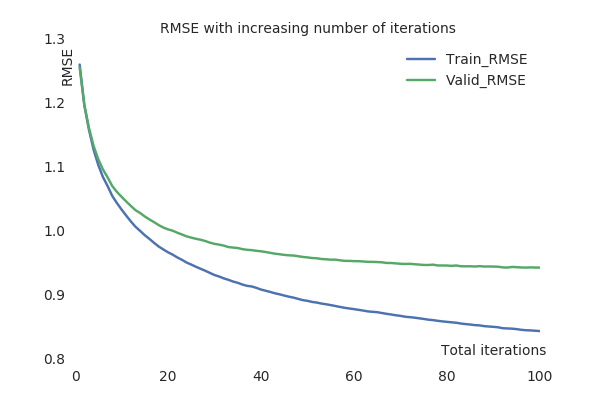

In [17]:
#W, H = factorize_matrix()
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(list(range(1,num_iterations+1)), global_tarin_rmse, label='Train_RMSE')
ax.plot(list(range(1,num_iterations+1)), global_valid_rmse, label='Valid_RMSE')
ax.legend()
ax.set_xlabel('Total iterations')
ax.set_ylabel('RMSE')
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.yaxis.set_label_coords(0, 0.92)
ax.xaxis.set_label_coords(0.9, 0.05)
ax.set_title("RMSE with increasing number of iterations",fontsize=10)
display(fig)

### Get the model

In [19]:
run_time = {}

In [20]:
start_time = time.time()
# do DSGD Matrix Factorization
W, H = factorize_matrix()
run_time['DSGD'] = time.time() - start_time

In [21]:
run_time['DSGD']

Out[ 68 ]: 23.576606512069702

In [22]:
get_rmse(test_matrix, W, H)

Out[ 40 ]: 0.99904617553068775

### Movie Recommendation

In [24]:
movies = pd.read_csv('/dbfs/FileStore/tables/movies0.csv')

In [25]:
def movie_recs(userid, W, H, topX):
    """
        Get the topX recommended movie for the user
    """
    if userid < 1 or userid > 610:
        print('invalid userId !')
        return
    movie_title = []
    movie_rated_title = []
    V_predicted = W.dot(H)
    
    # Get the rated movies
    index = list(V[userid-1].nonzero()[0])
    movie_rated_list = V[userid-1,index]
    z0 = zip(index, movie_rated_list)
    top_rated_movie = sorted(z0, key = lambda x:x[1], reverse = True)
    rated_id = [x[0] for x in top_rated_movie][:topX]
    rated_rating = [x[1] for x in top_rated_movie][:topX]
    movie_rated_id = [movie_mapping[x] for x in rated_id]
    for id in movie_rated_id:
        movie_rated_title.append(movies[movies.movieId == id]['title'].values[0])
    
    # Get the no rating movies
    no_rating_index = [x for x in list(range(V_predicted.shape[1])) if x not in index]
    movie_rating_list = V_predicted[userid-1,no_rating_index]
    z = zip(no_rating_index, movie_rating_list)
    top_recs_movie = sorted(z, key = lambda x:x[1], reverse = True)
    recs_id = [x[0] for x in top_recs_movie][:topX]
    recs_rating = [x[1] for x in top_recs_movie][:topX]
    movie_id = [movie_mapping[x] for x in recs_id]
    for id in movie_id:
        movie_title.append(movies[movies.movieId == id]['title'].values[0])
    return pd.DataFrame({'title':movie_rated_title,'score':rated_rating}), pd.DataFrame({'title':movie_title,'score':recs_rating})

In [26]:
# Get the top movies user i rated and will like
user1_rated, user1_Like = movie_recs(1, W, H, 5)
user1_rated, user1_Like

Out[ 69 ]: 
( score title
 0 5.0 Seven (a.k.a. Se7en) (1995)
 1 5.0 Usual Suspects, The (1995)
 2 5.0 Bottle Rocket (1996)
 3 5.0 Rob Roy (1995)
 4 5.0 Canadian Bacon (1995),
 score title
 0 6.693673 Gaslight (1944)
 1 6.653281 John Wick: Chapter Two (2017)
 2 6.476372 U.S. vs. John Lennon, The (2006)
 3 6.281851 Brave New World (1998)
 4 6.250861 City of Women, The (Città delle donne, La) (1980))

## ALS model

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

ratings_pd = spark.read.load('/FileStore/tables/ratings0.csv', format='csv', header = True).toPandas()
for idx, row in ratings_pd.iterrows():
    row[0] = int(row[0])
    row[1] = int(row[1])
    row[2] = float(row[2])
ratings = spark.createDataFrame(ratings_pd)
training, testing = ratings.randomSplit([0.8, 0.2])

In [29]:
# Build the recommendation model using ALS on the training data
start_time = time.time()
als = ALS(maxIter=10, regParam=0.05, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)
run_time['ALS'] = time.time() - start_time

In [30]:
# Evaluate the model by computing the RMSE on the testing data
predictions = model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9419342293369953

In [31]:
print('DSGD: {:.2f}'.format(run_time['DSGD']), '\nALS: {:.2f}'.format(run_time['ALS']))

DSGD: 57.86 
ALS: 6.34

In [32]:
print('DSGD: {:.2f}'.format(run_time['DSGD']))

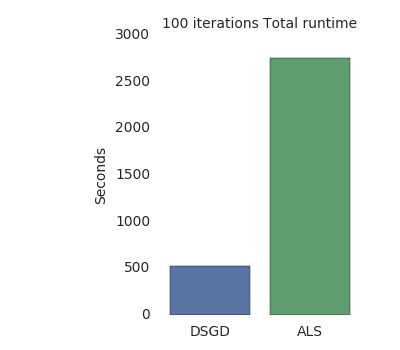

In [33]:
fig, ax = plt.subplots(figsize=(4, 3.5))
plt.subplots_adjust(left=0.4)
ax = sns.barplot(x=list(run_time.keys()), y=list(run_time.values()))
ax.set_ylabel('Seconds')
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
#ax.yaxis.set_label_coords(-0.2, 1)
ax.set_title("100 iterations Total runtime",fontsize=10)
display(fig)

In [34]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [35]:
userRecs = userRecs.toPandas()
movieRecs = movieRecs.toPandas()

In [36]:
userRecs.loc[userRecs['userId'] == 2]['recommendations']

Out[ 150 ]: 
548 [(417, 6.63682746887207), (1464, 6.53980016708...
Name: recommendations, dtype: object